
1. Objective: Identify trending topics in a large dataset of book reviews and analyze the sentiment related to each topic for strategic insights.

2. Data preparation and text vectorization

3. Clustering and dimensionality reduction

6.  Topic naming

7. Key Findings: Clusters and Sentiment Distribution



# Libraries

In [4]:
# Libraries

from pandarallel import pandarallel
import sys
import nltk
import nltk
import ssl
import seaborn as sns
from sentence_transformers import SentenceTransformer

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("wordnet")
sys.path.append("..")
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm

import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import sys
from flashtext import KeywordProcessor
from constant import MAPPING_OVERALL_TO_SENTIMENT, MAPPING_SENTIMENT_TO_NUMBER

from data_preprocessors.data_cleaner import DataCleaner
from data_preprocessors.spacy_analyzer import SpacyAnalyzer
from data_preprocessors.correction_heuristics_executor import (
    CorrectionHeuristicsExecutor,
)

pandarallel.initialize(progress_bar=True, nb_workers=10)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arturtanona/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arturtanona/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# About dataset

Source: [Kaggle - Amazon Books Reviews](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews)

This dataset contains approximately 3 million book reviews for 212,404 unique books, along with user information for each review. However I used only 140000 rows to conduct the Exploratory Data Analysis (EDA). Let's delve deeply into the data!

In [5]:
# !rm -R ../data
!mkdir -p  ../data

In [44]:
# train_data = next(pd.read_csv("../Books_rating.csv", chunksize=10000, names=['asin', 'title', 'price', 'userId', 'profileName', 'reviewHelpfulness',
#        'overall', 'reviewTime', 'reviewSummary', 'reviewText']))
train_data = pd.read_csv(
    "../Books_rating.csv",
    names=[
        "asin",
        "title",
        "price",
        "userId",
        "profileName",
        "reviewHelpfulness",
        "overall",
        "reviewTime",
        "reviewSummary",
        "reviewText",
    ],
)

/var/folders/ph/bfnsqjgs6h94fqr63sv1_3t80000gn/T/ipykernel_52922/1947241950.py:3: DtypeWarning: Columns (2,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(


In [45]:
train_data = train_data.head(140000)

# Proprocessing training data

In order to get cleaner text (without typos and unknown words), I have:
- removed duplicated punctuations,
- converted emojis to the word equivalents (e.g. kiss mark),
- removed unknown words from pov of wordnet, 
- removed characters that occur more than 2 times consequtively, 
- converted compound words that are mistakenly written into separate words
etc. 


In [29]:
!rm -R train_spans # clean up resources

rm: train_spans: No such file or directory


The dataset contains initially 140000 rows. Let's collect infos about lemmas, part of sequence taggings. For this exercise I used SpacyAnalyzer processor, as well as custom CorrectionHeuristicsExecutor. This entire sequence is about reducing effect of typos and misclicks on the quality of the data (I used i.a. Viterbi algorithm).

In [32]:
data_cleaner.data.shape, train_data.shape

((140000, 10), (140000, 10))

In [30]:
data_cleaner = DataCleaner(train_data)
data_cleaner.preprocess()
data_cleaner.data = data_cleaner.data[
    ~(data_cleaner.data.reviewText == "")
].reset_index(drop=True)



06-25 07:00 data_preprocessors.data_cleaner INFO     Words that are uppercase are converted to lowercase


06-25 07:00 data_preprocessors.data_cleaner INFO     Contraction converted to two words sequences


06-25 07:00 data_preprocessors.data_cleaner INFO     HTML characters dropped


06-25 07:01 data_preprocessors.data_cleaner INFO     Emojis dropped


06-25 07:01 data_preprocessors.data_cleaner INFO     Duplicate punctuation removed


06-25 07:01 data_preprocessors.data_cleaner INFO     Removed more than 3 consecutive same characters


06-25 07:01 data_preprocessors.data_cleaner INFO     Add space after punctuation


06-25 07:01 data_preprocessors.data_cleaner INFO     Duplicate spaces removed
06-25 07:01 data_preprocessors.data_cleaner INFO     Cleaning process ended


In [46]:
data_cleaner.data.to_csv("../data//_train_after_cleaning.csv", encoding="utf-8")
analyzer = SpacyAnalyzer(
    path_to_data="../data//_train_after_cleaning.csv",
    chunk_size=30000,
    destination_folder="train_spans",
)
analyzer.extract_spacy_spans()
lemmas = analyzer.collect_info_about_words("lemma")
only_lemmas = [
    word[1] for sequence in lemmas for sentence in sequence for word in sentence
]
only_lemmas = list(set(only_lemmas))
data = pd.read_csv("../data//_train_after_cleaning.csv", index_col=0)
executor = CorrectionHeuristicsExecutor(only_lemmas)
texts = executor.preprocess(data)

In [10]:
with open("default_excluded_words.pkl", "rb") as f:
    correct_word_map_to_none = pickle.load(f)

with open("default_corrected_words.pkl", "rb") as f:
    correct_word_map = pickle.load(f)


text_lemmatized = [
    " ".join(" ".join([word[1].lower() for word in sentence]) for sentence in sequence)
    for sequence in lemmas
]

keyword_processor = KeywordProcessor()


for word, target_word in correct_word_map_to_none.items():
    keyword_processor.add_keyword(word, target_word)
for word, target_word in correct_word_map.items():
    keyword_processor.add_keyword(word, target_word)


new_texts = []
for i in tqdm(text_lemmatized):
    new_texts.append(keyword_processor.replace_keywords(i))

new_texts = [i.lower() for i in new_texts]

100%|████████████| 140000/140000 [00:20<00:00, 6737.44it/s]


In [11]:
data["cleaned sentences"] = texts

In [12]:
len(new_texts)

140000

In [13]:
data.shape

(140000, 11)

In [14]:
data["text_lematized"] = new_texts

In [15]:
data["length"] = train_data.reviewText.str.len()

In [16]:
# removing 30000 outliers
data = data[np.logical_and(data["length"] < 2500, data["length"] > 100)]

In [17]:
data.reset_index(drop=True).to_csv("../data/final_train_data.csv")

In [19]:
train_data.groupby("title").size().sort_values(ascending=False)

title
Hannibal                                                                                     1249
Jane Eyre (New Windmill)                                                                     1190
The Picture of Dorian Gray (Classic Collection (Brilliance Audio))                           1184
The Five Love Languages: The Secret to Love that Lasts                                        985
A Christmas Carol (Classic Fiction)                                                           957
                                                                                             ... 
Information Technology Consulting and Other Professional Services Agreements Line by Line       1
Inheriting Scotland                                                                             1
The Cambridge Companion to Spinoza (Cambridge Companions to Philosophy)                         1
The Cambridge Companion to Renaissance Humanism (Cambridge Companions to Literature)            1
Mind, Brain, a

# Short overview

Cleaned data contains unique 124601 reviews  on 15103 books. Some of them are spams, some laconic, some are examples of the very good piece of writing. 

In [47]:
train_data = pd.read_csv("../../../old-one/data/final_train_data.csv")

In [48]:
len(train_data.reviewText.unique())

124601

In [49]:
len(train_data.title.unique())

15103

In [50]:
print(
    train_data[
        train_data.reviewText.str.len() == train_data.reviewText.str.len().max()
    ].reviewText.values[0][:1000]
)

This new trend in advice books aimed for women has all the sensationalism ( and staying power) of Reality tv or other " yellow" forms of entertainment. i realize the title and writing is sensationalized in order to sell lots of books and make the author a nice pile of royalty checks, is this really an advancement in relationships between the sexes? i wanted to give it one star, but i realize, if you want to play a game along the lines recommended in this book, you can manipulate another human being and keep them in a relationship. But my question is- if you have to resort to such tactics, and if the other person is willing to continuously submit to such tactics, what kind of long- term relationship are you hoping to achieve? Like i posted about another ill- fated book of advice on modern marriage, if i were a divorce lawyer, I would be sending out complimentary copies of this book all across my locale with my name and number affixed to the front cover, and just wait five years. there i

In [51]:
try:
    print(train_data[train_data.reviewText.str.len() < 100].reviewText.values[0][:1000])
except:
    pass

In [52]:
train_data["sentiment"] = train_data["overall"].apply(
    lambda x: MAPPING_OVERALL_TO_SENTIMENT[x]
)

06-25 07:22 matplotlib.category INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
06-25 07:22 matplotlib.category INFO     Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


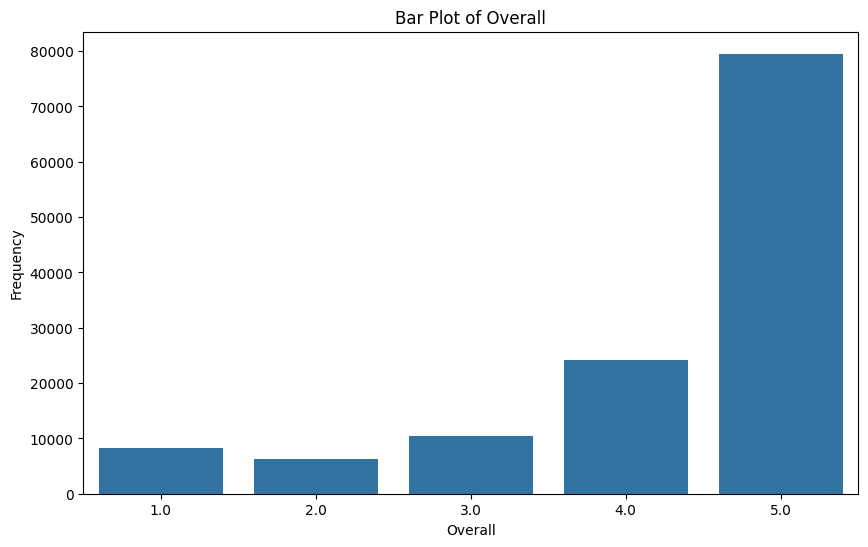

In [65]:
plt.figure(figsize=(10, 6))
ordered_overall = sorted(train_data['overall'].fillna(3.0).unique())
sns.countplot(x="overall", data=train_data, order=ordered_overall)

plt.title("Bar Plot of Overall")
plt.xlabel("Overall")
plt.ylabel("Frequency")
plt.show()

# Vocab analysis

Analysis of vocabulary from a part of speech perspective might be useful, especially if we would like to examine how the text of a typical review is constructed.

In [40]:
analyzer = SpacyAnalyzer(
    path_to_data="../data/final_train_data.csv",
    chunk_size=30000,
    destination_folder="../train_spans/",
)
poses = analyzer.collect_info_about_words("pos")

<Axes: ylabel='Frequency'>

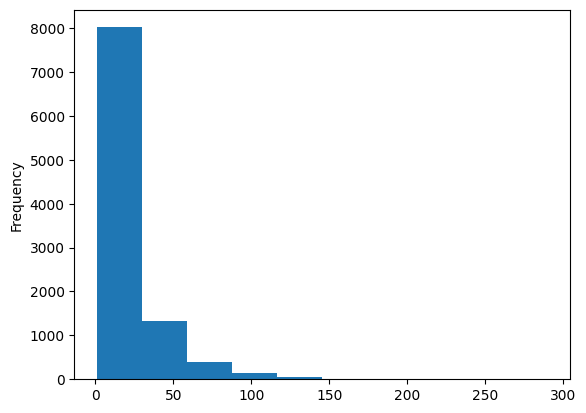

In [41]:
counted_poses = [
    Counter([word[1] for sentence in sequence for word in sentence])
    for sequence in poses
]

counted_poses = [dict(count) for count in counted_poses]


poses_matrix = pd.DataFrame(counted_poses)

poses_matrix["NOUN"].plot.hist()

In [42]:
noun_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "NOUN"
]
verb_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "VERB"
]
adjective_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "ADJ"
]

In [43]:
noun_occurences = Counter(noun_occurences)

In [44]:
results = sorted(dict(noun_occurences), key=lambda x: noun_occurences[x], reverse=True)
{key: noun_occurences[key] for key in results[:30]}

{'book': 12458,
 'story': 7745,
 'characters': 3364,
 'series': 3002,
 'author': 2518,
 'books': 2502,
 'love': 2165,
 'time': 2110,
 'way': 1891,
 'read': 1875,
 'life': 1864,
 'one': 1379,
 'romance': 1280,
 'character': 1153,
 'things': 1097,
 'stories': 1093,
 'lot': 1082,
 'end': 1035,
 'people': 1020,
 'man': 959,
 'world': 951,
 'bit': 920,
 'part': 839,
 'family': 832,
 'review': 808,
 'plot': 803,
 'sex': 785,
 'relationship': 756,
 's': 731,
 'heart': 703}

In [45]:
verb_occurences = Counter(verb_occurences)

In [46]:
results = sorted(dict(verb_occurences), key=lambda x: verb_occurences[x], reverse=True)
{key: verb_occurences[key] for key in results[:30]}

{'read': 5160,
 'have': 2894,
 's': 2613,
 'get': 2332,
 'had': 2085,
 'love': 2044,
 'loved': 1940,
 'reading': 1906,
 'has': 1905,
 'know': 1747,
 'see': 1568,
 'want': 1469,
 'enjoyed': 1468,
 'think': 1312,
 'like': 1281,
 'find': 1275,
 'going': 1241,
 'make': 1234,
 'wait': 1148,
 'written': 1136,
 'recommend': 1103,
 'do': 1094,
 'say': 1042,
 'made': 1032,
 'found': 985,
 'go': 982,
 'liked': 977,
 'put': 959,
 'feel': 918,
 "'": 863}

In [47]:
adjective_occurences = Counter(adjective_occurences)

In [50]:
results = sorted(
    dict(adjective_occurences), key=lambda x: adjective_occurences[x], reverse=True
)
selected_results = {key: adjective_occurences[key] for key in results[:50]}

In [51]:
selected_results

{'more': 3015,
 'good': 2923,
 'great': 2516,
 'other': 2207,
 'first': 1692,
 'little': 1585,
 'short': 1274,
 'next': 1221,
 'many': 1074,
 'new': 1027,
 'hot': 882,
 'interesting': 875,
 'much': 833,
 'different': 832,
 'best': 789,
 'own': 784,
 'few': 775,
 'real': 682,
 'bad': 679,
 'easy': 671,
 'sure': 617,
 'main': 570,
 'better': 567,
 'old': 532,
 'sweet': 530,
 'last': 521,
 'amazing': 519,
 'wonderful': 518,
 'young': 514,
 'same': 513,
 'sexy': 504,
 'whole': 499,
 'able': 486,
 'happy': 482,
 'honest': 479,
 'enough': 471,
 'nice': 461,
 'perfect': 459,
 'hard': 458,
 'strong': 458,
 'free': 447,
 'worth': 447,
 'full': 441,
 'second': 439,
 'most': 422,
 'only': 416,
 'true': 400,
 'quick': 392,
 'beautiful': 376,
 'big': 361}

Definitely, some words should be removed because they do not indicate any specific topic and could reduce the effectiveness of the TF-IDF vectorizer.

# Vocabulary analysis per ngram and sentiment type. 

Let's analyse corpus for mixed, negative and positive reviews from this perspective.

## Positive ngrams

In [52]:
@dataclass
class VectorizerData:
    ngram: int
    sentiment: str
    vectorizer: CountVectorizer
    sum_words: np.array
    words_freq: np.array

In [53]:
with open("stopwords-en.txt") as f:
    stop_words = f.read().splitlines()

In [54]:
def get_top_ngram(sentiment, n=None):
    # https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words=stop_words)
    bag_of_words = vectorizer.fit_transform(
        train_data[train_data.sentiment == sentiment]["reviewText"]
    )
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [
        (word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return VectorizerData(
        ngram=n,
        sentiment=sentiment,
        vectorizer=vectorizer,
        sum_words=sum_words,
        words_freq=words_freq,
    )

In [55]:
positive_1_gram = get_top_ngram("positive", 1)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

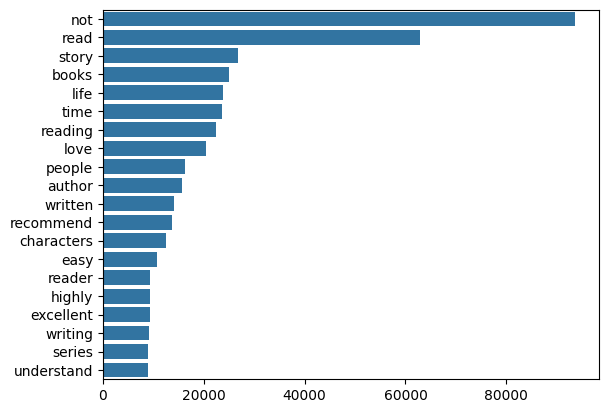

In [56]:
x, y = map(list, zip(*positive_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [57]:
positive_2_gram = get_top_ngram("positive", 2)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

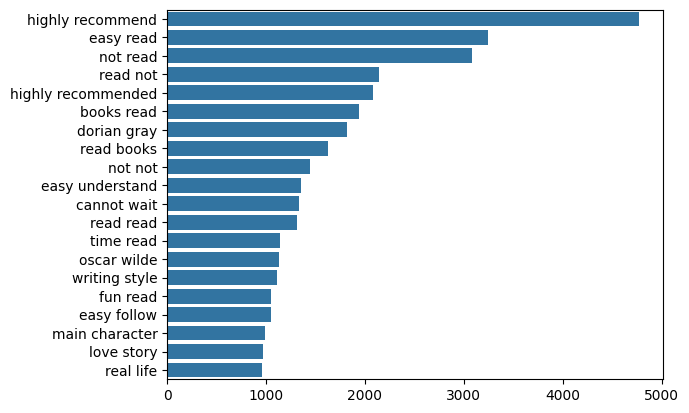

In [58]:
x, y = map(list, zip(*positive_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [59]:
positive_3_gram = get_top_ngram("positive", 3)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

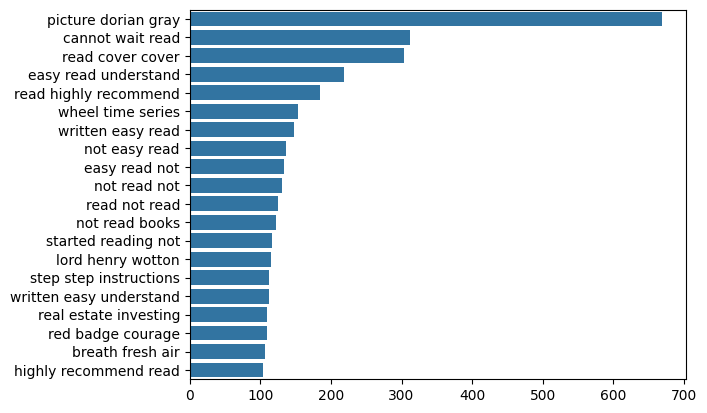

In [60]:
x, y = map(list, zip(*positive_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

## Negative ngrams

In [61]:
negative_1_gram = get_top_ngram("negative", 1)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

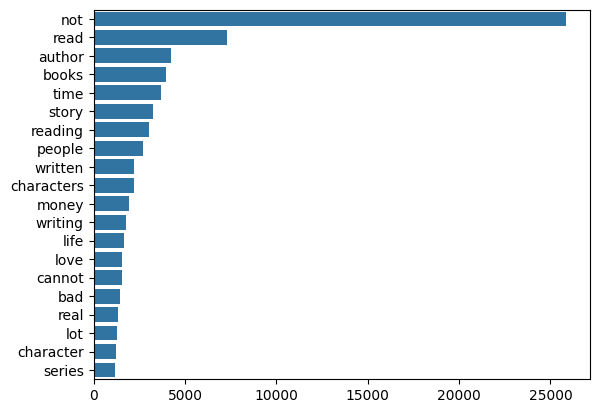

In [62]:
x, y = map(list, zip(*negative_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [63]:
negative_2_gram = get_top_ngram("negative", 2)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

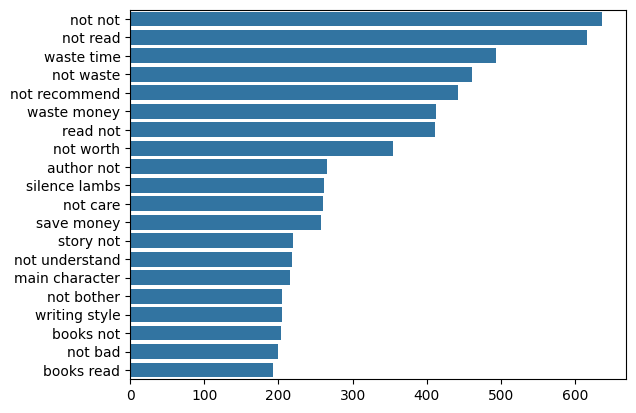

In [64]:
x, y = map(list, zip(*negative_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [65]:
negative_3_gram = get_top_ngram("negative", 3)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

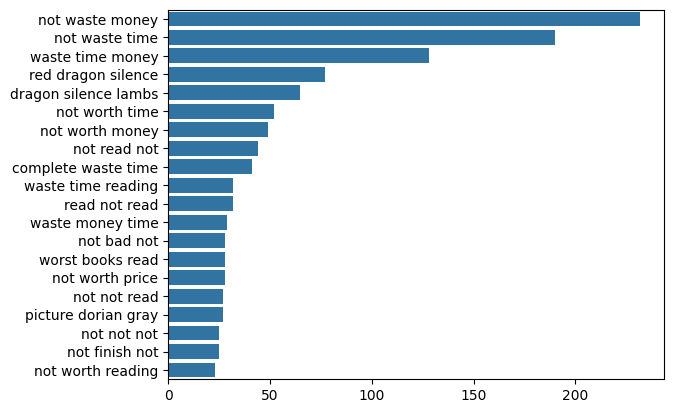

In [66]:
x, y = map(list, zip(*negative_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

## Mixed ngrams

In [67]:
mixed_1_gram = get_top_ngram("mixed", 1)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

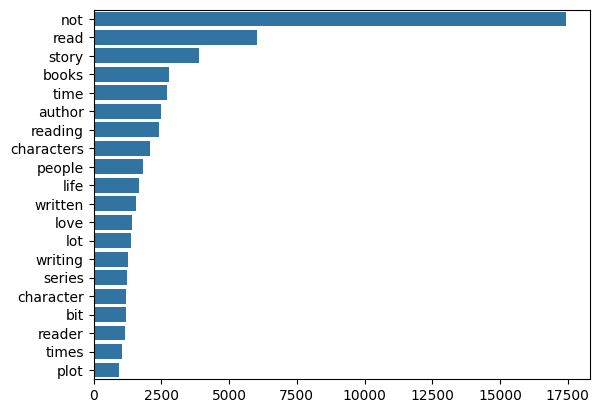

In [68]:
x, y = map(list, zip(*mixed_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [69]:
mixed_2_gram = get_top_ngram("mixed", 2)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

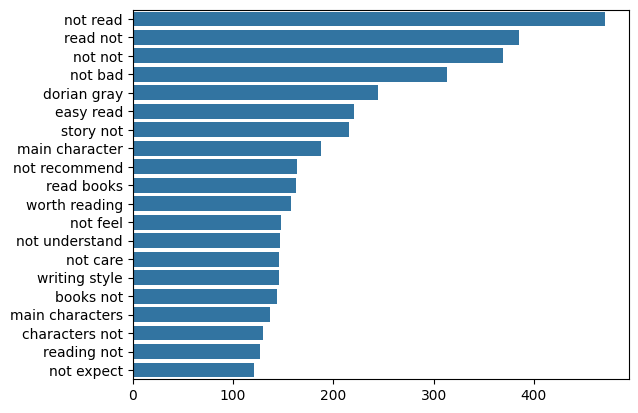

In [70]:
x, y = map(list, zip(*mixed_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [71]:
mixed_3_gram = get_top_ngram("mixed", 3)

/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

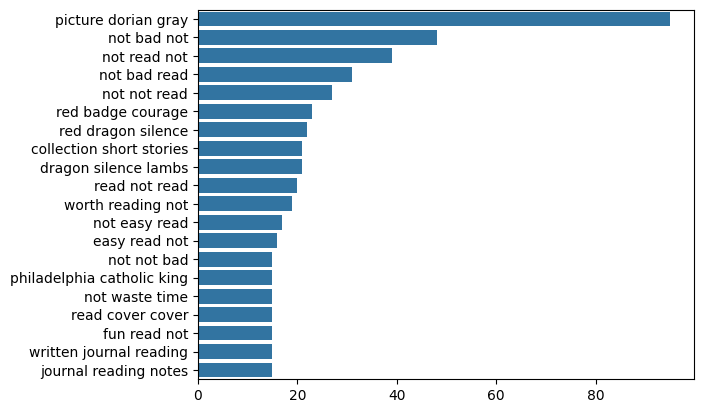

In [72]:
x, y = map(list, zip(*mixed_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

# Other features

In [73]:
train_data["total_length"] = train_data["reviewText"].apply(lambda x: len(x))
train_data["num_exclamation_marks"] = train_data["reviewText"].apply(
    lambda comment: comment.count("!")
)
train_data["num_question_marks"] = train_data["reviewText"].apply(
    lambda comment: comment.count("?")
)
train_data["num_punctuation"] = train_data["reviewText"].apply(
    lambda comment: sum(comment.count(w) for w in ".,;:")
)
train_data["num_symbols"] = train_data["reviewText"].apply(
    lambda comment: sum(comment.count(w) for w in "*&$%")
)

In [74]:
train_data["mapped_sentiment"] = train_data["sentiment"].apply(
    lambda x: MAPPING_SENTIMENT_TO_NUMBER[x]
)

In [75]:
corr = train_data[train_data["sentiment"].isin(["positive", "negative"])][
    [
        "total_length",
        "num_exclamation_marks",
        "num_question_marks",
        "num_punctuation",
        "num_symbols",
        "mapped_sentiment",
    ]
].corr()

06-24 20:30 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x4a81cfee0>


<Axes: >

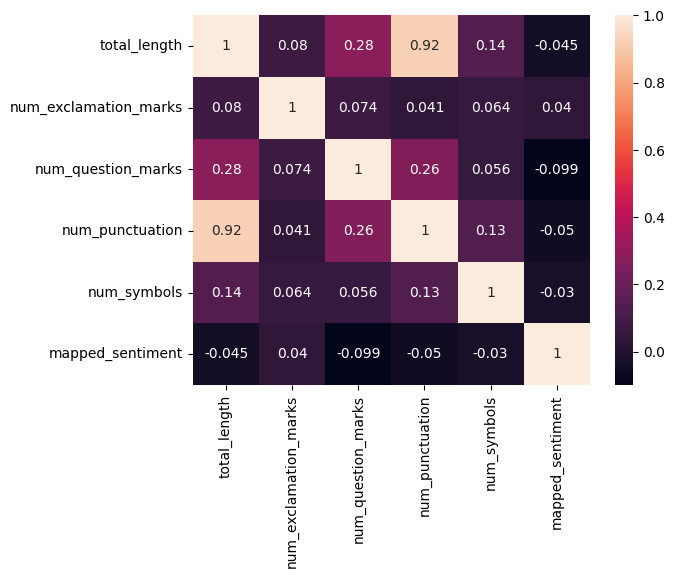

In [76]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

We can see that punctuation those features are not correlated with mapped sentiment. It means that we can remove them from the analysis.

Source of idea: https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw

# Lengths

Most of the reviews are between 0 and 500 characters length.

In [77]:
lengths = train_data.reviewText.apply(lambda x: len(x.split()))

<Axes: ylabel='Frequency'>

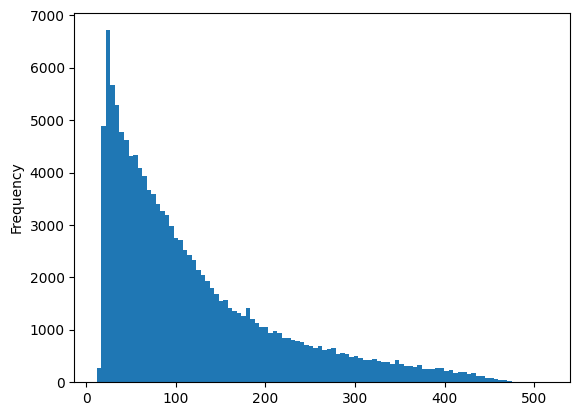

In [78]:
lengths.plot.hist(bins=100)

In [79]:
train_data["lengths"] = lengths

In [80]:
train_data = train_data[train_data["lengths"] < 1000].reset_index(drop=True)

In [81]:
train_data = train_data[
    (1000 > train_data["lengths"]) & (train_data["lengths"] > 10)
].reset_index(drop=True)

In [82]:
train_data.to_csv("../data/final_train_data.csv")

# Next steps - topic modelling with unsupervised ML algorithm!

Punctuation is important from the perspective of sentence embedding transformer - it can change the entire context of information. On the other hand, in the traditional ML (e.g. TfIDF) it should be pruned. So let's TFIDF-vectorize data and train some topic model.


Topic modeling is a statistical approach in machine learning and natural language processing designed to uncover abstract topics within a set of documents. These models facilitate the exploration and comprehension of extensive text data by detecting patterns in word co-occurrence.

There are many applications for topic modeling. In information retrieval, it enhances search results by organizing and grouping related documents. In recommendation systems, it improves user experience by suggesting content based on identified themes. Additionally, it is utilized in social media analysis to measure public sentiment and trends by pinpointing common topics in user-generated content. This can answer the following question:

## What topics get the worst reviews? 

# Libraries

In [1]:
from pandarallel import pandarallel
import numpy as np

pandarallel.initialize(progress_bar=True, nb_workers=10)
import pandas as pd
import json
import re
from dataclasses import dataclass
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm
import demoji
import emoji
from glob import glob
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import pandas as pd
from nltk.corpus import stopwords
import pandas as pd
import random
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import sys
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import sentence_transformers
from sklearn.cluster import AgglomerativeClustering
from keybert.backend import SentenceTransformerBackend
import seaborn as sns
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import numpy as np
import math
from keybert import KeyBERT
from tqdm.autonotebook import tqdm, trange
import time
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import StratifiedKFold

sys.path.append("..")

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/arturtanona/Documents/coursera/unsupervised-machine-learning/week4/old-one/venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Prepare vectors

### Load data

In [2]:
DATA_PATH = "../data/final_train_data.csv"
train_data = pd.read_csv(DATA_PATH, index_col=0)

## TfIDFVectors

We will use the TFIDF vectorizer as a simple encoder (note: it's not a real transformer) to feed arrays into the KMeans model.

The Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer is a statistical tool utilized in natural language processing and information retrieval to assess the significance of a word within a document relative to a larger set of documents, known as a corpus. It is often used to convert text data into numerical vectors that can serve as input for machine learning models.

How does it work? We need to understand two terms:

Term Frequency (TF): How frequently a term appears in a document.

Inverse Document Frequency (IDF): Reduces the significance of words that are common across all documents.
The process is as follows:

The text is broken down into words (tokens), typically converted to lowercase, and common stop words may be removed.
For each term in each document, compute the term frequency.
Compute the IDF value for each term across the entire corpus.
Multiply the TF value by the IDF value for each term, forming a vector for each document.

NOTE: this part of description was used by me also for BBC - week 4 assignment.

In [3]:
nltk.download("stopwords")
word_list = list(stopwords.words("english"))

stop_words = [
    word
    for word in word_list
    if word not in ["not", "no", "i", "my", "but", "my", "myself"]
]
stop_words += [punct for punct in string.punctuation]
vectorizer = CountVectorizer(stop_words=stop_words)
cv_fit = vectorizer.fit_transform(train_data.text_lematized)

words = np.asarray(cv_fit.sum(axis=0))

id2word = {id: word for word, id in vectorizer.vocabulary_.items()}

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [4]:
condition_range = np.logical_and(1000 > words[0], words[0] > 1)

new_stop_words = []
for i in np.argwhere(~condition_range):
    new_stop_words.append(id2word[i[0]])

keep_words = []
for i in np.argwhere(condition_range):
    keep_words.append(id2word[i[0]])

digit_pattern = re.compile("\d+")

keep_words = set([word for word in keep_words if not digit_pattern.search(word)])

len(new_stop_words), len(keep_words)
text_lemmatized = [
    " ".join([word.lower() for word in text.split() if word.lower() in keep_words])
    for text in train_data.text_lematized
]

train_data["text_lematized"] = text_lemmatized

In [5]:
train_data.to_csv("../data/lemmatized_data_final.csv")

# Prepare sampled data

In [6]:
train_data

,asin,title,price,userId,profileName,reviewHelpfulness,overall,reviewTime,reviewSummary,reviewText,...,text_lematized,length,sentiment,total_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,mapped_sentiment,lengths
0,0829814000,Wonderful Worship in Smaller Churches,19.40,AZ0IOBU20TBOP,Rev. Pamela Tinnin,8/10,5.0,991440000,Outstanding Resource for Small Church Pastors,"i just finished the book, "" wonderful Worship ...",...,worship smaller churches ray pastor reread reg...,788,positive,788,0,0,16,0,2,143
1,0829814000,Wonderful Worship in Smaller Churches,19.40,A373VVEU6Z9M0N,Dr. Terry W. Dorsett,1/1,5.0,1291766400,Small Churches CAN Have Wonderful Worship,Many small churches feel like they can not hav...,...,worship ray thou shalt humorous encouragement,349,positive,349,0,0,5,0,2,61
2,0829814000,Wonderful Worship in Smaller Churches,19.40,AGKGOH65VTRR4,"Cynthia L. Lajoy ""Cindy La Joy""",1/1,5.0,1248307200,Not Just for Pastors!,i just finished reading this amazing book and ...,...,entirely congregation ministry depressed accom...,1273,positive,1273,2,0,15,0,2,225
3,0829814000,Wonderful Worship in Smaller Churches,19.40,A3OQWLU31BU1Y,Maxwell Grant,1/1,5.0,1222560000,Small church pastor? This is the book on worship,i had not been a small church pastor very long...,...,pastor ray handful anthony pa pp carl dudley r...,1022,positive,1022,1,0,20,0,2,192
4,0595344550,Whispers of the Wicked Saints,10.95,A3Q12RK71N74LB,Book Reader,7/11,1.0,1117065600,not good,i bought this book because i read some glowing...,...,glow praise criticise urgent editing possibly ...,1023,negative,1023,0,2,21,0,0,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128556,061813512X,The Complete Meat Cookbook,23.10,ASMJXT3DO4D02,"Degalisto ""DCL""",0/0,5.0,1265932800,good book,i am 58 and am a very good cook and i cook a l...,...,massive cooking meat stove oven cooking complaint,514,positive,514,0,0,11,0,2,105
128557,061813512X,The Complete Meat Cookbook,23.10,A1GC87J92WHHUJ,Karl E. Buettner,0/0,5.0,1264032000,Meat Bible,a must! Not only a great cookbook - the writte...,...,meat,102,positive,102,1,0,1,0,2,21
128558,061813512X,The Complete Meat Cookbook,23.10,AXQL0REDIA9C6,K. Wooley,0/0,5.0,1232150400,Fantastic - the best cookbook I own.,I have had this book for awhile now. You can j...,...,awhile meat meat perfectly,260,positive,260,1,0,4,0,2,48
128559,061813512X,The Complete Meat Cookbook,23.10,A2SUK9OWVNW9KU,Paula Ray,0/0,5.0,1031875200,The only guide you'll ever need.,This not only gives you recipes; it gives you ...,...,select meat ingredient roast steak lazy roast ...,392,positive,392,0,0,9,0,2,75


In [7]:
train_data.groupby(["sentiment"]).count()

,asin,title,price,userId,profileName,reviewHelpfulness,overall,reviewTime,reviewSummary,reviewText,cleaned sentences,text_lematized,length,total_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,mapped_sentiment,lengths
sentiment,,,,,,,,,,,,,,,,,,,,
mixed,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500,10500
negative,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384,14384
positive,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677,103677


### Create input data

We want to identify topics using a clustering algorithm. First, we need to consider that each book is referenced by several reviews. Reviews for Book A will be different from reviews for Book B. Therefore, we should concatenate all reviews for each book into a single `text_lemmatized` column.

In [8]:
def sample_texts(group):
    return " ".join(group)


sampled_texts = (
    train_data.groupby("title")["text_lematized"].apply(sample_texts)
).to_dict()

In [9]:
unique_reviews = train_data[["userId", "asin"]].apply(
    lambda x: f'{x["userId"]}_{x["asin"]}', axis=1
)
train_data["composite_keys"] = train_data[["userId", "asin"]].apply(
    lambda x: f'{x["userId"]}_{x["asin"]}', axis=1
)
train_data = train_data[~train_data["sentiment"].isin(["mixed"])]
sampled_data = train_data[train_data["composite_keys"].isin(unique_reviews.unique())]
sampled_data["text_lematized"] = sampled_data["title"].apply(sampled_texts.get)
sampled_data = sampled_data.drop_duplicates("title")
vectorizer = TfidfVectorizer(stop_words=stop_words + new_stop_words)
vectors = vectorizer.fit_transform(sampled_data["text_lematized"])

We end up with unique rows, where each row represents one book. The column "test_lemmatized" contains all reviews for that book.

In [10]:
vectors

<14692x54000 sparse matrix of type '<class 'numpy.float64'>'
	with 1356542 stored elements in Compressed Sparse Row format>

The number of features is very large, so let's reduce them using TruncatedSVD. Why should we use it? TruncatedSVD enhances computational efficiency by lowering the number of features, which speeds up processing and reduces memory usage. This optimization is crucial for large datasets where machine learning model training can be resource-intensive. It's especially beneficial for sparse matrices, like those in text data represented as TF-IDF matrices, as it can generate dense vectors without losing the data's structural integrity.

In [11]:
svd = TruncatedSVD(n_components=1000, random_state=42)
X_after_svd = svd.fit_transform(vectors)

## KMeans - hyperparameter search

The primary assumption is that we do not want to have too many topics. We aim to limit them to an absolute maximum of 250. Additionally, it is crucial that we do not end up with too many clusters; ideally, we should have around 100. Having more clusters would make the analysis redundant. Our goal is to facilitate quick business decisions without excessive granularity. Introducing too many clusters would make the entire analysis unreadable (there is no value into bringing 10000 clusters, if there are 14000 titles)

When processing large datasets, especially text-heavy datasets like book reviews, clustering algorithms can be incredibly useful for identifying underlying patterns and groupings. Among the many clustering algorithms available, K-Means stands out for several reasons. 

K-Means is simple and efficient. It works well with large datasets and scales linearly with the size of the dataset, making it suitable for the 100000 book reviews. It quickly partitions the data into distinct clusters based on feature similarities, providing a clear structure of the data.

We will perform hyperparameter search using 4 factors - n_clusters, algorithm, init method and max_iter.

In [12]:
range_n_clusters = range(50, 300, 50)
algorithm = ["lloyd", "elkan"]
init = ["k-means++", "random"]
max_iter = [100, 200, 300]

ssd = []
labels = {}
grid_search_results = []

hyperparameter_combinations = list(
    itertools.product(range_n_clusters, algorithm, init, max_iter)
)

for params in tqdm(hyperparameter_combinations):
    print(params)
    n_clusters, alg, init_method, iterations = params
    start_time = time.time()

    kmeans = KMeans(
        n_clusters=n_clusters,
        algorithm=alg,
        init=init_method,
        max_iter=iterations,
        random_state=0,
    )
    kmeans.fit(X_after_svd)
    ssd_value = kmeans.inertia_
    ssd.append(ssd_value)
    end_time = time.time()

    result = {
        "n_clusters": n_clusters,
        "algorithm": alg,
        "init": init_method,
        "max_iter": iterations,
        "ssd": ssd_value,
        "time": end_time - start_time,
    }
    grid_search_results.append(result)

    labels[params] = kmeans.labels_

best_config = min(grid_search_results, key=lambda x: x["ssd"])
print("Best configuration:")
print(best_config)

  0%|          | 0/60 [00:00<?, ?it/s]

(50, 'lloyd', 'k-means++', 100)
(50, 'lloyd', 'k-means++', 200)
(50, 'lloyd', 'k-means++', 300)
(50, 'lloyd', 'random', 100)
(50, 'lloyd', 'random', 200)
(50, 'lloyd', 'random', 300)
(50, 'elkan', 'k-means++', 100)
(50, 'elkan', 'k-means++', 200)
(50, 'elkan', 'k-means++', 300)
(50, 'elkan', 'random', 100)
(50, 'elkan', 'random', 200)
(50, 'elkan', 'random', 300)
(100, 'lloyd', 'k-means++', 100)
(100, 'lloyd', 'k-means++', 200)
(100, 'lloyd', 'k-means++', 300)
(100, 'lloyd', 'random', 100)
(100, 'lloyd', 'random', 200)
(100, 'lloyd', 'random', 300)
(100, 'elkan', 'k-means++', 100)
(100, 'elkan', 'k-means++', 200)
(100, 'elkan', 'k-means++', 300)
(100, 'elkan', 'random', 100)
(100, 'elkan', 'random', 200)
(100, 'elkan', 'random', 300)
(150, 'lloyd', 'k-means++', 100)
(150, 'lloyd', 'k-means++', 200)
(150, 'lloyd', 'k-means++', 300)
(150, 'lloyd', 'random', 100)
(150, 'lloyd', 'random', 200)
(150, 'lloyd', 'random', 300)
(150, 'elkan', 'k-means++', 100)
(150, 'elkan', 'k-means++', 200)
(

In [13]:
df = pd.DataFrame(grid_search_results)
df.sort_values("ssd", ascending=True)

,n_clusters,algorithm,init,max_iter,ssd,time
56,250,elkan,k-means++,300,3527.025724,4.259114
55,250,elkan,k-means++,200,3527.025724,4.489664
54,250,elkan,k-means++,100,3527.025724,4.040841
50,250,lloyd,k-means++,300,3527.025724,3.024500
49,250,lloyd,k-means++,200,3527.025724,3.658699
48,250,lloyd,k-means++,100,3527.025724,3.163834
59,250,elkan,random,300,3626.353101,19.075625
57,250,elkan,random,100,3626.353101,19.226897
53,250,lloyd,random,300,3626.353101,12.652875
52,250,lloyd,random,200,3626.353101,12.273168


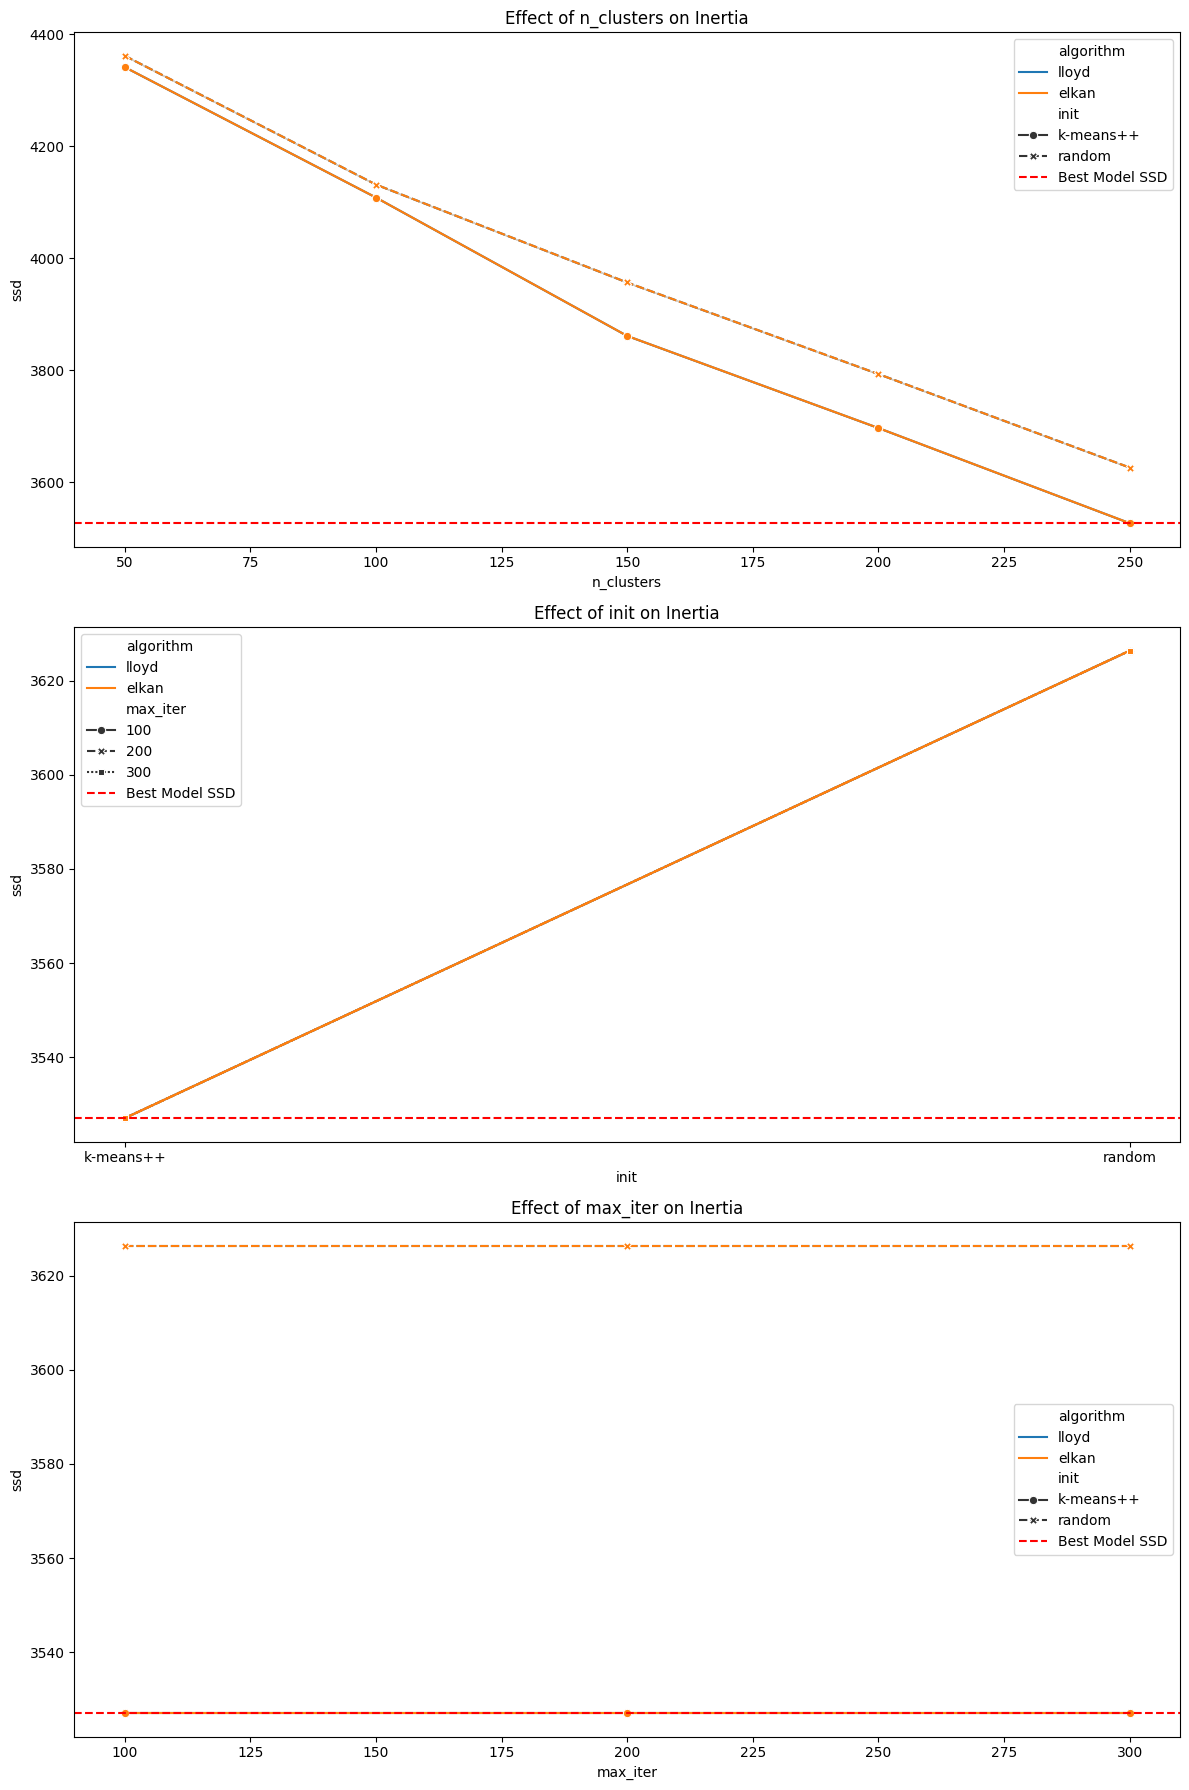

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
df = pd.DataFrame(grid_search_results)
sns.lineplot(
    data=df,
    x="n_clusters",
    y="ssd",
    hue="algorithm",
    style="init",
    markers=True,
    ax=axes[0],
)
axes[0].axhline(3527.0257237283304, ls="--", color="red", label="Best Model SSD")
axes[0].set_title("Effect of n_clusters on Inertia")
axes[0].legend()

filtered_df = df[df["n_clusters"] == 250]
sns.lineplot(
    data=filtered_df,
    x="init",
    y="ssd",
    hue="algorithm",
    style="max_iter",
    markers=True,
    ax=axes[1],
)
axes[1].axhline(3527.0257237283304, ls="--", color="red", label="Best Model SSD")
axes[1].set_title("Effect of init on Inertia")
axes[1].legend()

sns.lineplot(
    data=filtered_df,
    x="max_iter",
    y="ssd",
    hue="algorithm",
    style="init",
    markers=True,
    ax=axes[2],
)
axes[2].axhline(3527.0257237283304, ls="--", color="red", label="Best Model SSD")
axes[2].set_title("Effect of max_iter on Inertia")
axes[2].legend()

plt.tight_layout()
plt.show()

As observed, changing the `n_clusters` parameter is the only factor that affects the inertia level.

In [15]:
best_config

{'n_clusters': 250,
 'algorithm': 'lloyd',
 'init': 'k-means++',
 'max_iter': 100,
 'ssd': 3527.0257237283304,
 'time': 3.1638338565826416}

In [16]:
kmeans = KMeans(
    **{"n_clusters": 250, "algorithm": "lloyd", "init": "k-means++", "max_iter": 100}
)
kmeans.fit(X_after_svd)

KMeans(max_iter=100, n_clusters=250)

# Naming clusters and creating topics

Let's name the topics using the KeyBert library.

1. Sample examples from the library.
2. Name the topic using the three most common words.
3. Check the distribution of words.
4. Group by negative and positive ratios.

KeyBert utilizes the "paraphrase-MiniLM-L6-v2" model, which is a transformer model optimized for extracting keywords. This transformer will be used to extract labels from the items.

BERT, an abbreviation for Bidirectional Encoder Representations from Transformers, is a transformer-based model designed for natural language processing tasks. Unlike conventional models, BERT processes text bidirectionally, taking into account the context from both the left and right sides of each word in a sentence. This enables BERT to grasp the nuanced meanings of words within various contexts. Its bidirectional nature enhances performance in tasks such as question answering and sentiment analysis. BERT is pre-trained on vast amounts of text and can be fine-tuned for specific applications, making it highly adaptable. Its architecture features multiple layers of encoders that handle text inputs simultaneously, boosting both efficiency and effectiveness in comprehending complex language. 

In [17]:
sampled_data["labels"] = kmeans.labels_

In [18]:
sampled_data["text_lematized"]

0         worship smaller churches ray pastor reread reg...
4         glow praise criticise urgent editing possibly ...
36        interplay diverse caribbean ongoing interactio...
37        everett ferguson ferguson peek christians crit...
40        saint hyacinth meeting rome witness saint domi...
                                ...                        
128460    speaking muslim summarize hadiths prophet muha...
128468     clarity stern berg vocabulary drawing hearing...
128542    castrate expurgate suit anxiety yamato graphic...
128543    december hopelessly killer wave accessible fon...
128544    decent occasionally burn glass sausage frequen...
Name: text_lematized, Length: 14692, dtype: object

In [19]:
def sample_texts(group):
    return " ".join([i[:50] for i in group])[:512]


sampled_texts = sampled_data.groupby("labels")["text_lematized"].apply(sample_texts)

In [20]:
model_name = "paraphrase-MiniLM-L6-v2"

st_model = sentence_transformers.SentenceTransformer(model_name, device="cpu")

kw_model = KeyBERT(model=SentenceTransformerBackend(st_model, batch_size=128))

In [21]:
found_keywords = []
review_texts = sampled_texts.values
batch_size = 128
for start_idx in tqdm(range(0, len(review_texts), batch_size)):
    end_idx = min(start_idx + batch_size, len(review_texts))

    batch_texts = review_texts[start_idx:end_idx]
    batch_keywords = kw_model.extract_keywords(batch_texts)

    found_keywords.extend(batch_keywords)

  0%|          | 0/2 [00:00<?, ?it/s]

In [22]:
def map_words_to_topics(ranked_words_list):
    topics = []
    for ranked_words in ranked_words_list:
        ranked_words.sort(key=lambda x: x[1], reverse=True)
        top_words = [word[0] for word in ranked_words[:3]]
        topic = "-".join(top_words)
        topics.append(topic)
    return topics

In [23]:
def convert_to_dict(data):
    result = {}
    for item in data:
        result[item["title"]] = item["topic"]
    return result

In [24]:
topics = map_words_to_topics(found_keywords)

In [25]:
sampled_data["topic"] = sampled_data["labels"].apply(lambda label: topics[label])

In [26]:
mapping = convert_to_dict(sampled_data[["title", "topic"]].to_dict(orient="records"))

In [27]:
len(set([i for i in mapping.values()]))

250

In [28]:
train_data["topic"] = train_data["title"].apply(mapping.get)

/var/folders/ph/bfnsqjgs6h94fqr63sv1_3t80000gn/T/ipykernel_33495/2586612064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["topic"] = train_data["title"].apply(mapping.get)


In [29]:
len(train_data["topic"].unique())

250

# Topics

In [51]:
train_data.groupby(["topic"]).size().sort_values()

topic
lee-seller-jam                       1
java-integrity-syntax                2
anthology-inclusion-homa             4
russian-dep-international            5
ottn-publishing-involvement          5
                                 ...  
celiac-pastry-bake                1727
obscenity-portraiture-conjure     2405
reformational-taht-gospel         3636
criticis-apologist-yoruba        22744
glow-dare-praise                 43082
Length: 250, dtype: int64

We have unique 250 clusters. We can see from below histogram that number of the clusters vary - and  the largest one have around 3000, 22744, and 43082 titles. We can treat them as otuliers. Large clusters might mask underlying structures and relationships within the data. Important subgroups or patterns within those large clusters might be lost, which compromises the quality and interpretability of the clustering result.

The most of the clusters contains between 1 and 50 positions.

<Axes: >

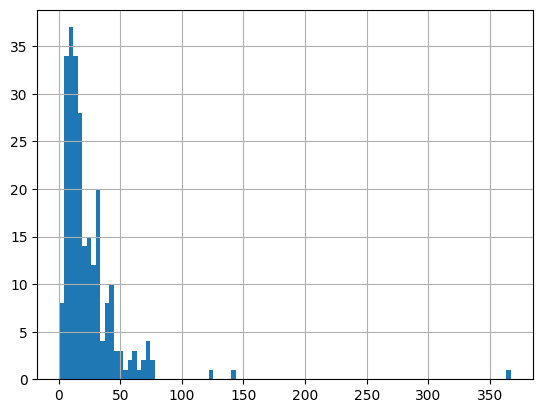

In [49]:
train_data[["topic", "title"]].drop_duplicates("title").groupby(
    ["topic"]
).size().sort_values()[:-2].hist(bins=100)

In [ ]:
train_data[["topic", "title"]]

## How many topics tend to generate the most negative reactions from the audience?

In [31]:
sentiment_counts = (
    train_data.groupby(["topic", "sentiment"]).size().unstack(fill_value=0)
)

In [32]:
sentiment_counts

sentiment,negative,positive
topic,,
abortion-proponent-philoso,2,35
addiction-addictio-addicted,22,215
adhd-drs-prescr,9,157
adoption-adopt-adoptive,11,125
advertising-ad-marketing,10,40
...,...,...
worship-psalms-protest,11,26
wrestling-wrestle-wrestlecrap,16,46
xml-wm-flash,30,270


In [40]:
topics_with_more_neg = sentiment_counts[
    sentiment_counts["negative"] > sentiment_counts["positive"]
].index

In [41]:
topics_with_more_neg

Index([], dtype='object', name='topic')

**There is no cluster with more negative sentiments overall.** However, we can identify which cluster has the highest proportion of negative sentiments.

In [42]:
sentiment_counts["total_sentiments"] = (
    sentiment_counts["negative"] + sentiment_counts["positive"]
)
sentiment_counts["proportion_negative"] = (
    sentiment_counts["negative"] / sentiment_counts["total_sentiments"]
)

In [45]:
sentiment_counts.sort_values("proportion_negative", ascending=False)

sentiment,negative,positive,total_sentiments,proportion_negative
topic,,,,
anthology-inclusion-homa,2,2,4,0.500000
java-integrity-syntax,1,1,2,0.500000
clep-exam-civ,28,34,62,0.451613
double-twin-reprint,71,113,184,0.385870
cave-cavern-exploration,8,15,23,0.347826
...,...,...,...,...
literacy-oxford-educator,0,13,13,0.000000
forgiveness-forgiver-forgive,0,32,32,0.000000
timely-fault-flip,0,5,5,0.000000


Two first results are not relevant, because they contain very small sample of reviews in my opinion. The third one looks like relevant (62 records). It looks like the exams ('clap-exam-civ')topics are giving the most number of emotion. 

In [48]:
train_data[train_data['topic'] == 'clep-exam-civ'][['title', 'overall', 'reviewText', 'topic']]

,title,overall,reviewText,topic
21777,Western Civilization: Combined Volume,5.0,This book is an excellent resource for prepari...,clep-exam-civ
21778,Western Civilization: Combined Volume,5.0,"i actually love this book. First, i used it to...",clep-exam-civ
21779,Western Civilization: Combined Volume,5.0,i used this text in my ap European History cou...,clep-exam-civ
21780,Western Civilization: Combined Volume,5.0,i bought this book based off of another person...,clep-exam-civ
21781,Western Civilization: Combined Volume,5.0,i purchased this book for homeschool learning ...,clep-exam-civ
...,...,...,...,...
94860,CLEP General Exams w/ CD-ROM (CLEP Test Prepar...,5.0,"Great resource, the cd was great because it wa...",clep-exam-civ
94861,CLEP General Exams w/ CD-ROM (CLEP Test Prepar...,1.0,i studied this book to an obsessive level for ...,clep-exam-civ
94863,CLEP General Exams w/ CD-ROM (CLEP Test Prepar...,5.0,"i have passed a lot of Cleps, and rea has help...",clep-exam-civ
94864,CLEP General Exams w/ CD-ROM (CLEP Test Prepar...,2.0,The cd was only helpful as a test- taking prac...,clep-exam-civ


# Conclusion and to do-s



The primary objective of this analysis was to identify trending topics in a dataset of approximately book reviews for 14000 unique books. We aimed to cluster these reviews into actionable segments and analyze the sentiment (positive or negative) related to each topic. 

Methodology:
1. **Data Preparation:** 
2. **Text Vectorization with TF-IDF Vectorizer:** 
3. **Clustering and Dimensionality Reduction:**
4. **Cluster Analysis and Topic Naming:**

#### Findings:

- **Clusters:** 250 meaningful clusters were formed.
   - **Cluster Size Distribution:** Most clusters have between 1 to 50 titles.
- **Sentiment Distribution:** Preliminary analyses indicate that certain topics, such as exams (e.g., 'clap-exam-civ'), have a higher concentration of emotionally charged reviews.


The analysis successfully leveraged traditional machine learning methods such as TF-IDF and Truncated SVD instead of computationally expensive transformers, providing a scalable solution for large datasets. Limiting the number of topics and clusters ensures the results are actionable and aligned with business needs. Further examination of sentiment-related insights can support strategic decisions for publishers and authors, highlighting areas for improvement and emerging trends in literary content.

Another approaches that needs to be used:
* agglomerative clusering,
* FINCH algorithm
* LDA

# Sources

https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

https://www.analyticsvidhya.com/blog/2023/02/topic-modeling-using-latent-dirichlet-allocation-lda/#:~:text=Topic%20modeling%20is%20a%20versatile,within%20a%20corpus%20of%20documents.

https://towardsdatascience.com/elbow-clustering-for-artificial-intelligence-be9c641d9cf8 

https://jalammar.github.io/illustrated-transformer/
